In [ ]:
conda install -c conda-forge wordcloud

In [ ]:
pip install squarify

In [ ]:
pip install plotly

In [87]:
import pandas as pd
import numpy as np
import string
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import collections
import itertools
import matplotlib.pyplot as plt
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import squarify
import seaborn as sns
import plotly.express as px
%matplotlib inline

#  1. Reuters Health Data #

# Part A

In [19]:
reuters_df = pd.read_csv('reuters_health.csv', header = None)

In [20]:
reuters_df.head()

,0,1,2,3,4
0,5.862830e+17,Thu Apr 09 21:40:16 +0000 2015,Los Angeles closes 500 medical marijuana shops,NaN,NaN
1,5.862790e+17,Thu Apr 09 21:24:27 +0000 2015,U.S. cuts poultry export forecast as deadly bi...,NaN,NaN
2,5.862730e+17,Thu Apr 09 21:04:15 +0000 2015,Fears over Roundup herbicide residues prompt p...,NaN,NaN
3,5.862550e+17,Thu Apr 09 19:49:50 +0000 2015,Liberia watchdog says some Ebola funds unaccou...,NaN,NaN
4,5.862440e+17,Thu Apr 09 19:07:10 +0000 2015,Diabetes devices may interfere with avalanche ...,NaN,NaN


We will work on the third column and will rename it as news.

In [113]:
news_df = reuters_df[2]
news_df = pd.DataFrame(news_df)
news_df['news'] = news_df[2]
news_df.drop([2], axis = 1, inplace = True)

1. To check whether there is HTML in the column or not.

In [114]:
html = []
for string in news_df['news']:
    html.append(bool(BeautifulSoup(string, "html.parser").find()))

In [115]:
sum(html)

0

so, there are no HTML text present in the column. 

But,  we will prepare the function for removing HTML

In [24]:
def remove_html(text):
    soup = BeautifulSoup(text, 'lmxl')
    html_free = soup.get_text()
    return html_free

2. (a) Removing punctuation

In [30]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [25]:
def remove_punct(text):
    no_punct = "".join([word for word in text if word not in string.punctuation])
    return no_punct

In [31]:
news_df.loc[:, ('news')] = news_df.loc[:, ('news')].apply(lambda x: remove_punct(x))

In [32]:
news_df.head()

,news
0,Los Angeles closes 500 medical marijuana shops
1,US cuts poultry export forecast as deadly bird...
2,Fears over Roundup herbicide residues prompt p...
3,Liberia watchdog says some Ebola funds unaccou...
4,Diabetes devices may interfere with avalanche ...


2. (b) Tokenization

In [33]:
tokenizer = RegexpTokenizer(r'\w+')

In [34]:
news_df.loc[:, ('news')] = news_df.loc[:, ('news')].apply(lambda x: tokenizer.tokenize(x.lower()))

In [35]:
news_df.head()

,news
0,"[los, angeles, closes, 500, medical, marijuana..."
1,"[us, cuts, poultry, export, forecast, as, dead..."
2,"[fears, over, roundup, herbicide, residues, pr..."
3,"[liberia, watchdog, says, some, ebola, funds, ..."
4,"[diabetes, devices, may, interfere, with, aval..."


3. Removing stop words

In [36]:
def stop_words_remover(text):
    remover = [words for words in text if words not in stopwords.words('english')]
    return remover

In [37]:
news_df.loc[:, ('news')] = news_df.loc[:, ('news')].apply(lambda x: stop_words_remover(x))

In [38]:
news_df.head()

,news
0,"[los, angeles, closes, 500, medical, marijuana..."
1,"[us, cuts, poultry, export, forecast, deadly, ..."
2,"[fears, roundup, herbicide, residues, prompt, ..."
3,"[liberia, watchdog, says, ebola, funds, unacco..."
4,"[diabetes, devices, may, interfere, avalanche,..."


4. Lemmatizing

In [39]:
lemmatizer = WordNetLemmatizer()

In [40]:
def lemmatize(text):
    lem_text = [lemmatizer.lemmatize(i) for i in text]
    return lem_text

In [41]:
news_df.loc[:, ('news')] = news_df.loc[:, ('news')].apply(lambda x: lemmatize(x))

In [42]:
news_df.head()

,news
0,"[los, angeles, close, 500, medical, marijuana,..."
1,"[u, cut, poultry, export, forecast, deadly, bi..."
2,"[fear, roundup, herbicide, residue, prompt, pr..."
3,"[liberia, watchdog, say, ebola, fund, unaccoun..."
4,"[diabetes, device, may, interfere, avalanche, ..."


5. Word frequency

In [43]:
#preparing a list before. #

In [44]:
word_list = [i for i in news_df['news']]

In [45]:
# list of all words along the word list prepared. #

In [46]:
all_words = list(itertools.chain(*word_list))
count_word = collections.Counter(all_words)
count_word.most_common(20)

[('ebola', 1271),
 ('u', 669),
 ('drug', 513),
 ('may', 317),
 ('say', 270),
 ('study', 257),
 ('health', 237),
 ('patient', 232),
 ('cancer', 212),
 ('new', 205),
 ('fda', 188),
 ('rt', 183),
 ('case', 170),
 ('hospital', 164),
 ('risk', 144),
 ('outbreak', 137),
 ('africa', 137),
 ('vaccine', 128),
 ('test', 127),
 ('flu', 122)]

In [47]:
# creating a dataframe for the first 20 most common words. #
most_common_df = pd.DataFrame(count_word.most_common(20), columns = ['word', 'count'])

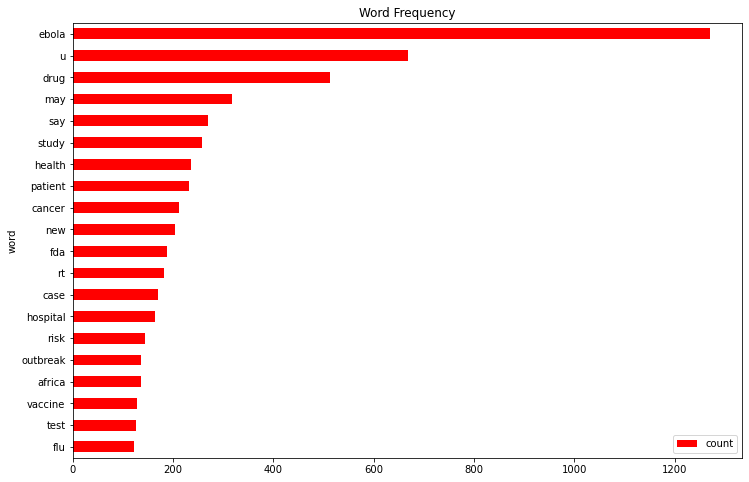

In [48]:
fig, ax = plt.subplots(figsize = (12,8))
most_common_df.sort_values(by = 'count').plot.barh(x = 'word', y = 'count', ax = ax, color = 'red')
ax.set_title('Word Frequency')
plt.show()

6. NGrams

In [49]:
# we will have to prepare a list to get the most common words used together. 

In [50]:
ngram_list = [word_list for word_list in news_df['news']]

In [51]:
# now we will flatten the list.

In [52]:
flattened_list = list(itertools.chain(*ngram_list))

In [53]:
#we will work on unigrams. #

In [54]:
unigram_series = pd.Series(nltk.ngrams(flattened_list, 1)).value_counts()[:20]

Text(0, 0.5, 'Unigram')

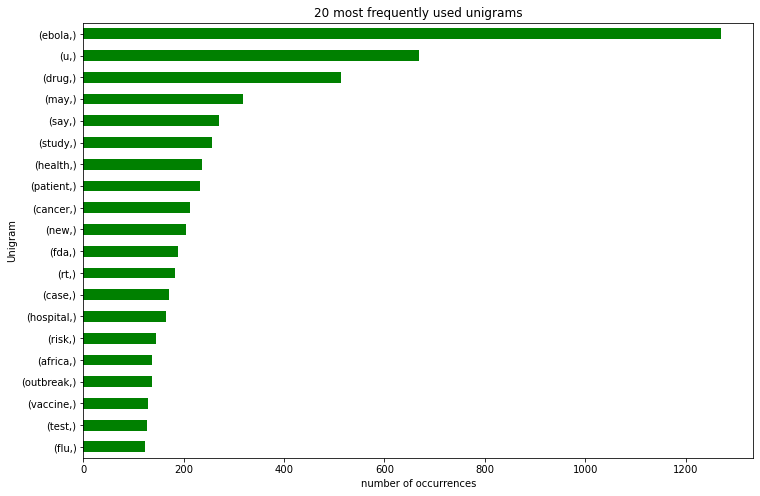

In [55]:
unigram_series.sort_values().plot.barh(color = 'green', figsize = (12,8))
plt.title('20 most frequently used unigrams')
plt.xlabel('number of occurrences')
plt.ylabel('Unigram')

In [56]:
# we will work on bigrams. #

In [57]:
bigram_series = pd.Series(nltk.ngrams(flattened_list, 2)).value_counts()[:20]

Text(0, 0.5, 'Bigram')

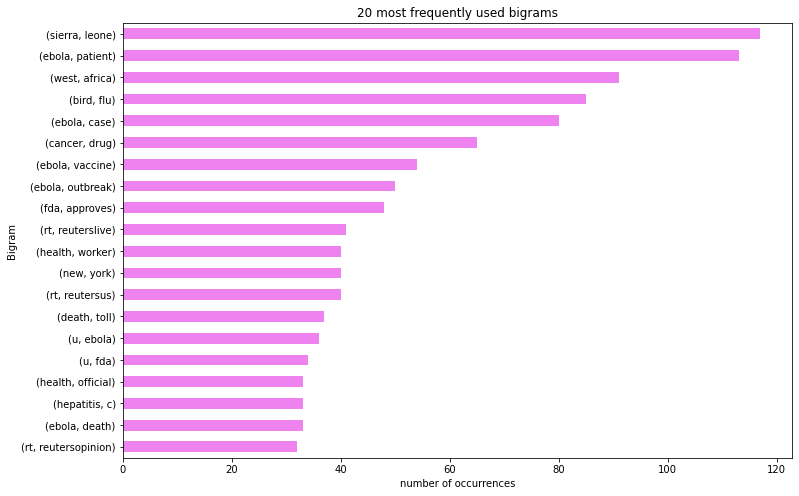

In [58]:
bigram_series.sort_values().plot.barh(color = 'violet', figsize = (12,8))
plt.title('20 most frequently used bigrams')
plt.xlabel('number of occurrences')
plt.ylabel('Bigram')

In [59]:
# trigram series#

In [60]:
trigram_series = pd.Series(nltk.ngrams(flattened_list, 3)).value_counts()[:20]

Text(0.5, 0, 'Trigram')

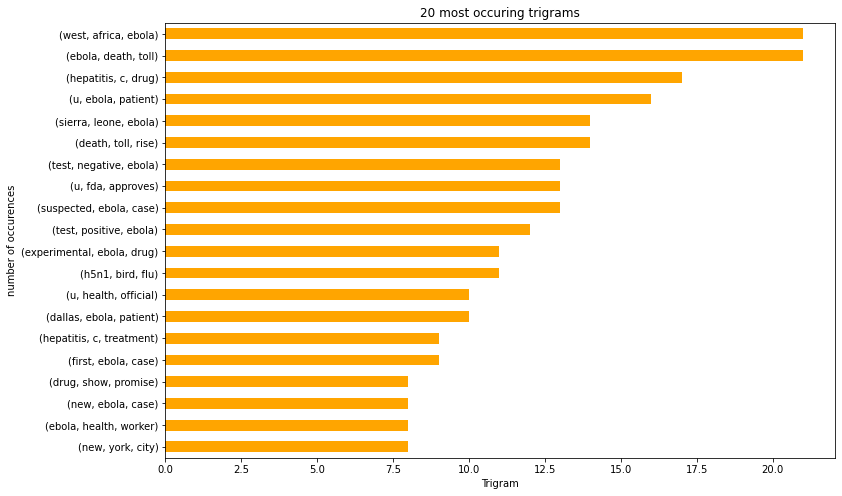

In [61]:
trigram_series.sort_values().plot.barh(color = 'orange', figsize = (12,8))
plt.title('20 most occuring trigrams')
plt.ylabel('number of occurences')
plt.xlabel('Trigram')

# Part B

1. Word Cloud

In [71]:
def word_cloud(text):
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'black').generate(str(text))
    fig = plt.figure(
        figsize = (40, 30),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

In [67]:
#word_cloud_df = news_df

In [ ]:
#word_cloud_df['news'].apply(lambda x: " ".join([word for word in x]))

In [69]:
#word_cloud_text = word_cloud_df.values

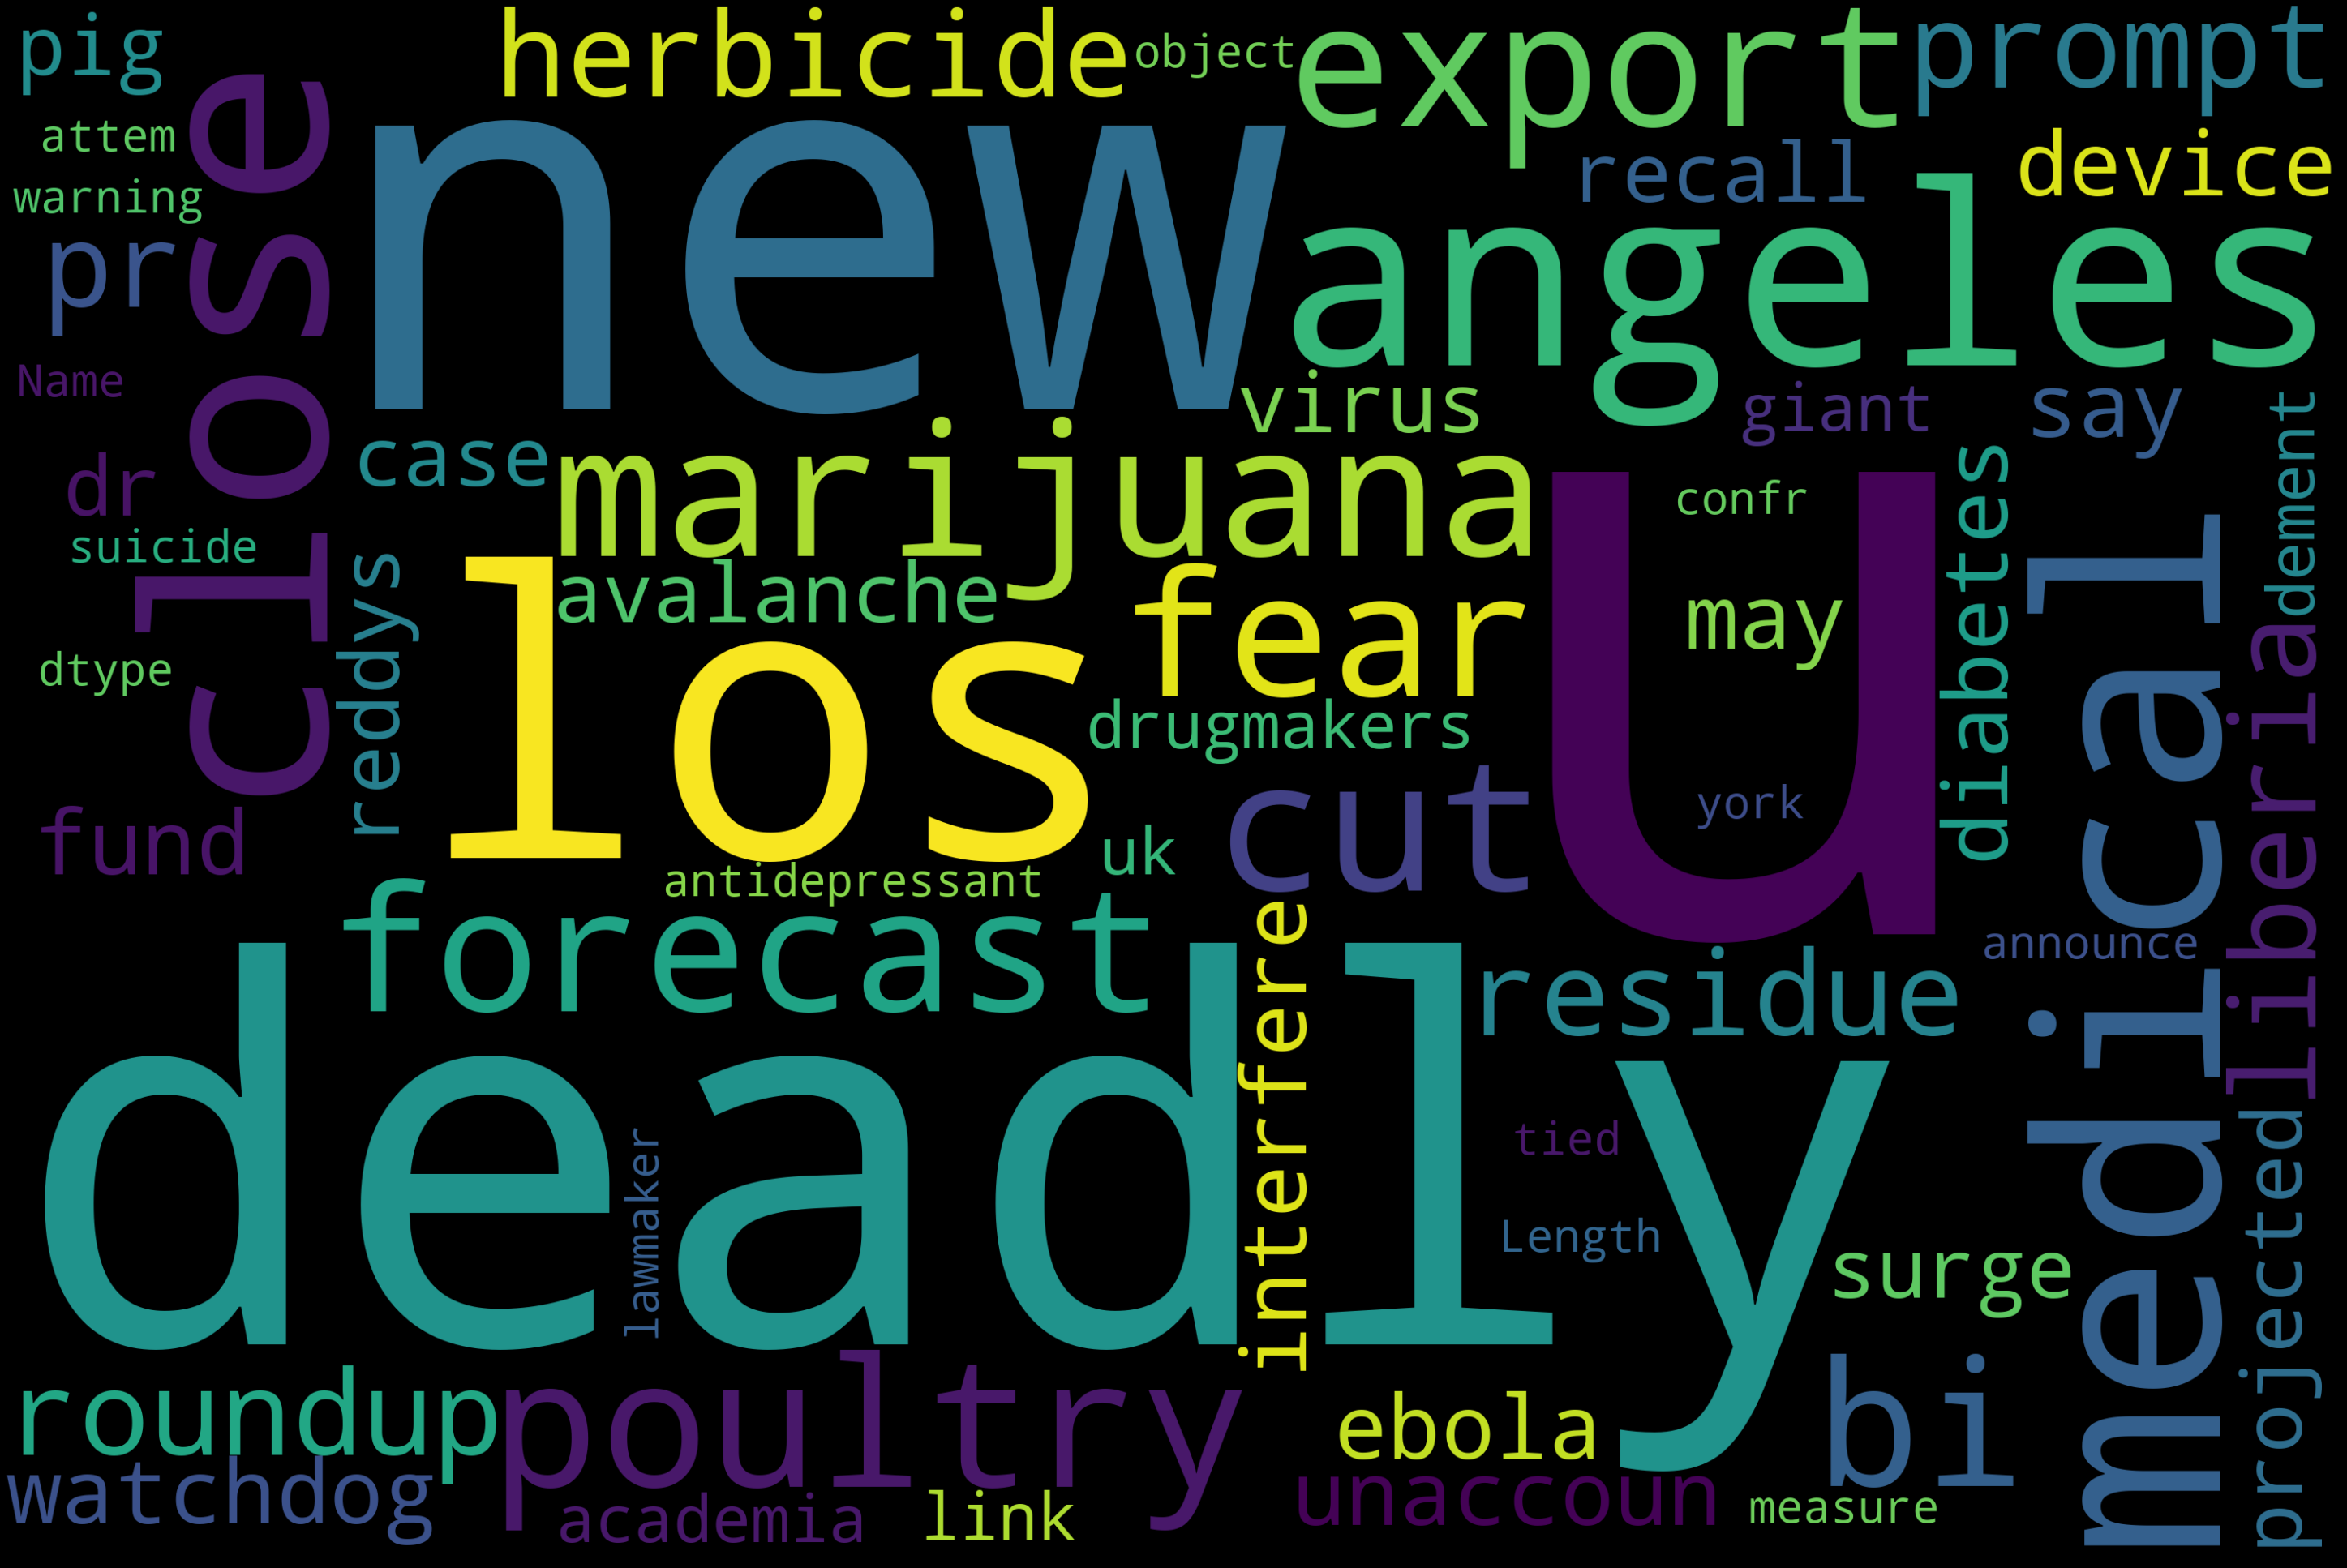

In [73]:
word_cloud(news_df['news'])

2. Tree map

In [76]:
# we will work on the most_common_df

Text(0.5, 1.0, 'Tree Map')

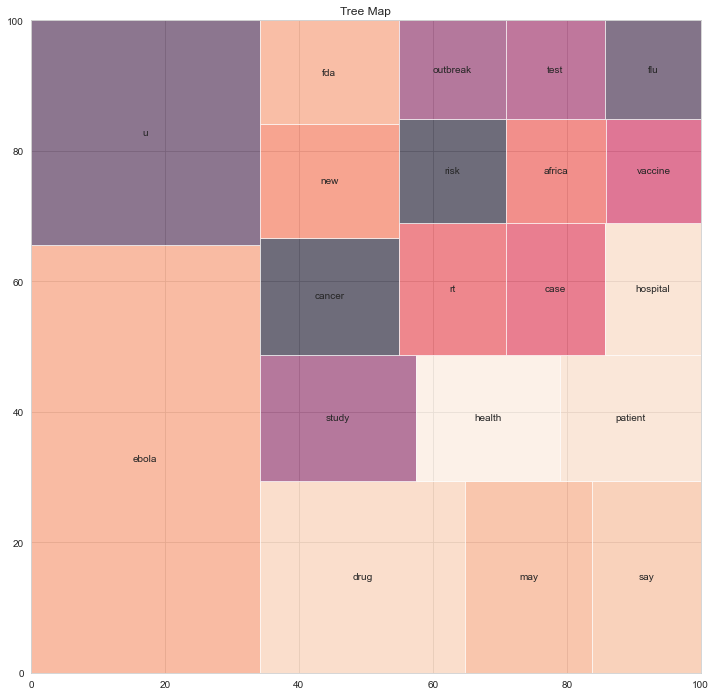

In [84]:
plt.figure(figsize = (12, 12))
sns.set_style(style = "whitegrid")
sizes = most_common_df['count'].values
label = most_common_df['word']
squarify.plot(sizes = sizes, label = label, alpha = 0.6)
plt.title("Tree Map")

3. Bubble Chart

In [93]:
graph = px.scatter(most_common_df, x = "word", y = "count", hover_name = "word", size = "count", color = "word")

In [94]:
graph.show()

# 2. Kaiser Health Data 

# Part 1

In [98]:
kaiser_df = pd.read_csv("KaiserHealthNews.csv", header = None)

In [99]:
kaiser_df.head()

,0,1,2,3,4,5,6,7
0,5.862670e+17,Thu Apr 09 20:37:18 +0000 2015,Tougher Vaccine Law In Calif. Clears First Hur...,NaN,NaN,NaN,NaN,NaN
1,5.862600e+17,Thu Apr 09 20:11:29 +0000 2015,A new sort of extracurricular activity: seeing...,NaN,NaN,NaN,NaN,NaN
2,5.862390e+17,Thu Apr 09 18:46:24 +0000 2015,Houston firefighters have another tool at thei...,NaN,NaN,NaN,NaN,NaN
3,5.861820e+17,Thu Apr 09 15:00:25 +0000 2015,Will #Montana expand its #Medicaid program? So...,NaN,NaN,NaN,NaN,NaN
4,5.861590e+17,Thu Apr 09 13:30:44 +0000 2015,Rand Paul's campaign first day: abortion and t...,NaN,NaN,NaN,NaN,NaN


In [110]:
news_k_df = kaiser_df[2]
news_k_df.colummns = ['news']
news_k_df = pd.DataFrame(news_k_df)
news_k_df['news'] = news_k_df[2]
news_k_df.drop([2], axis = 1, inplace = True)

1. Removing url's.

In [116]:
html_k = []
for string in news_k_df['news']:
    html_k.append(bool(BeautifulSoup(string, "html.parser").find()))

In [117]:
sum(html_k)

0

In [118]:
# there are no url's present in the "news" column.

2. (a) removing punctuation. 

In [121]:
import string
news_k_df.loc[:, ('news')] = news_k_df.loc[:, ('news')].apply(lambda x: remove_punct(x))

2. (b) Tokenization

In [122]:
news_k_df.loc[:, ('news')] = news_k_df.loc[:, ('news')].apply(lambda x: tokenizer.tokenize(x.lower()))

3. Removing stop words.

In [123]:
news_k_df.loc[:, ('news')] = news_k_df.loc[:, ('news')].apply(lambda x: stop_words_remover(x))

4. Lemmatizing

In [124]:
news_k_df.loc[:, ('news')] = news_k_df.loc[:, ('news')].apply(lambda x: lemmatize(x))

5. Word frequency

In [125]:
word_list = [i for i in news_k_df['news']]
all_words = list(itertools.chain(*word_list)) # flattened list for 
count_word = collections.Counter(all_words)
count_word.most_common(20)

[('health', 843),
 ('today', 383),
 ('insurance', 370),
 ('law', 337),
 ('rt', 320),
 ('obamacare', 300),
 ('plan', 234),
 ('care', 232),
 ('medicare', 217),
 ('cartoon', 217),
 ('exchange', 214),
 ('medicaid', 208),
 ('state', 203),
 ('hospital', 190),
 ('coverage', 163),
 ('headline', 154),
 ('new', 152),
 ('httpkhnewshkmaub', 131),
 ('marketplace', 105),
 ('patient', 99)]

In [128]:
most_common_k_df = pd.DataFrame(count_word.most_common(20), columns = ['word', 'count'])

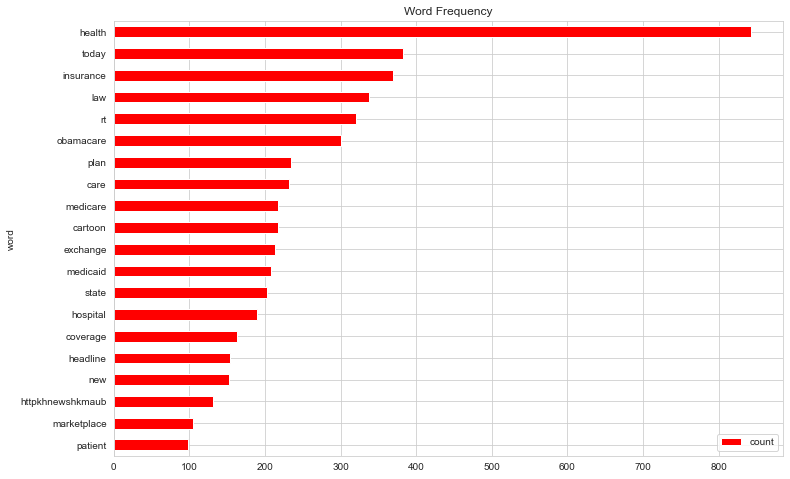

In [129]:
fig, ax = plt.subplots(figsize = (12,8))
most_common_k_df.sort_values(by = 'count').plot.barh(x = 'word', y = 'count', ax = ax, color = 'red')
ax.set_title('Word Frequency')
plt.show()

6. unigrams, bigrams and trigrams

Text(0, 0.5, 'Unigram')

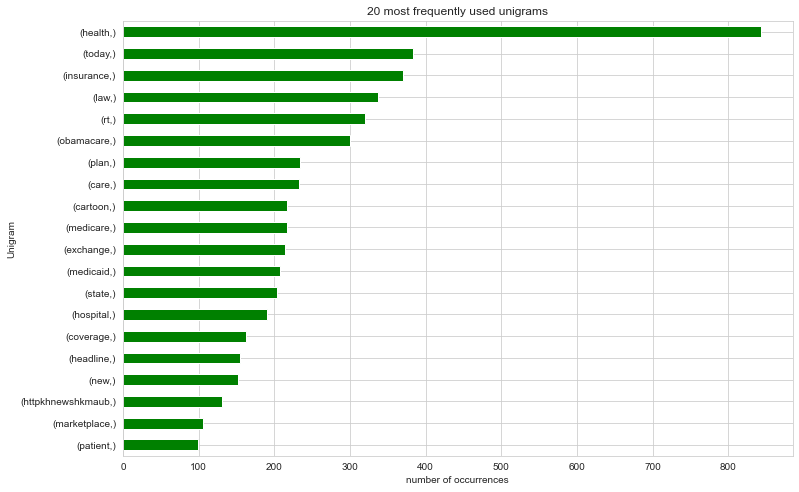

In [130]:
# unigrams
unigram_series = pd.Series(nltk.ngrams(all_words, 1)).value_counts()[:20]
unigram_series.sort_values().plot.barh(color = 'green', figsize = (12,8))
plt.title('20 most frequently used unigrams')
plt.xlabel('number of occurrences')
plt.ylabel('Unigram')

Text(0, 0.5, 'Unigram')

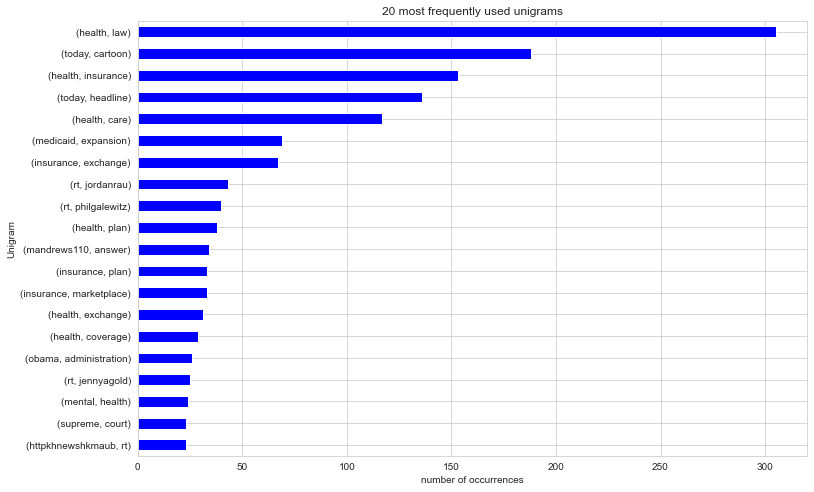

In [134]:
# bigrams
bigram_series = pd.Series(nltk.ngrams(all_words, 2)).value_counts()[:20]
bigram_series.sort_values().plot.barh(color = 'blue', figsize = (12,8))
plt.title('20 most frequently used unigrams')
plt.xlabel('number of occurrences')
plt.ylabel('Unigram')

Text(0, 0.5, 'Unigram')

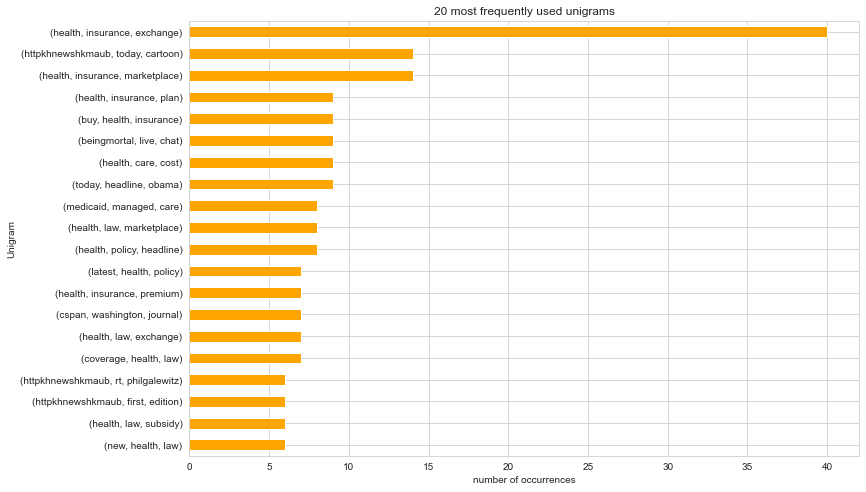

In [133]:
# trigrams
trigram_series = pd.Series(nltk.ngrams(all_words, 3)).value_counts()[:20]
trigram_series.sort_values().plot.barh(color = 'orange', figsize = (12,8))
plt.title('20 most frequently used unigrams')
plt.xlabel('number of occurrences')
plt.ylabel('Unigram')

# Part B

1. Word Cloud

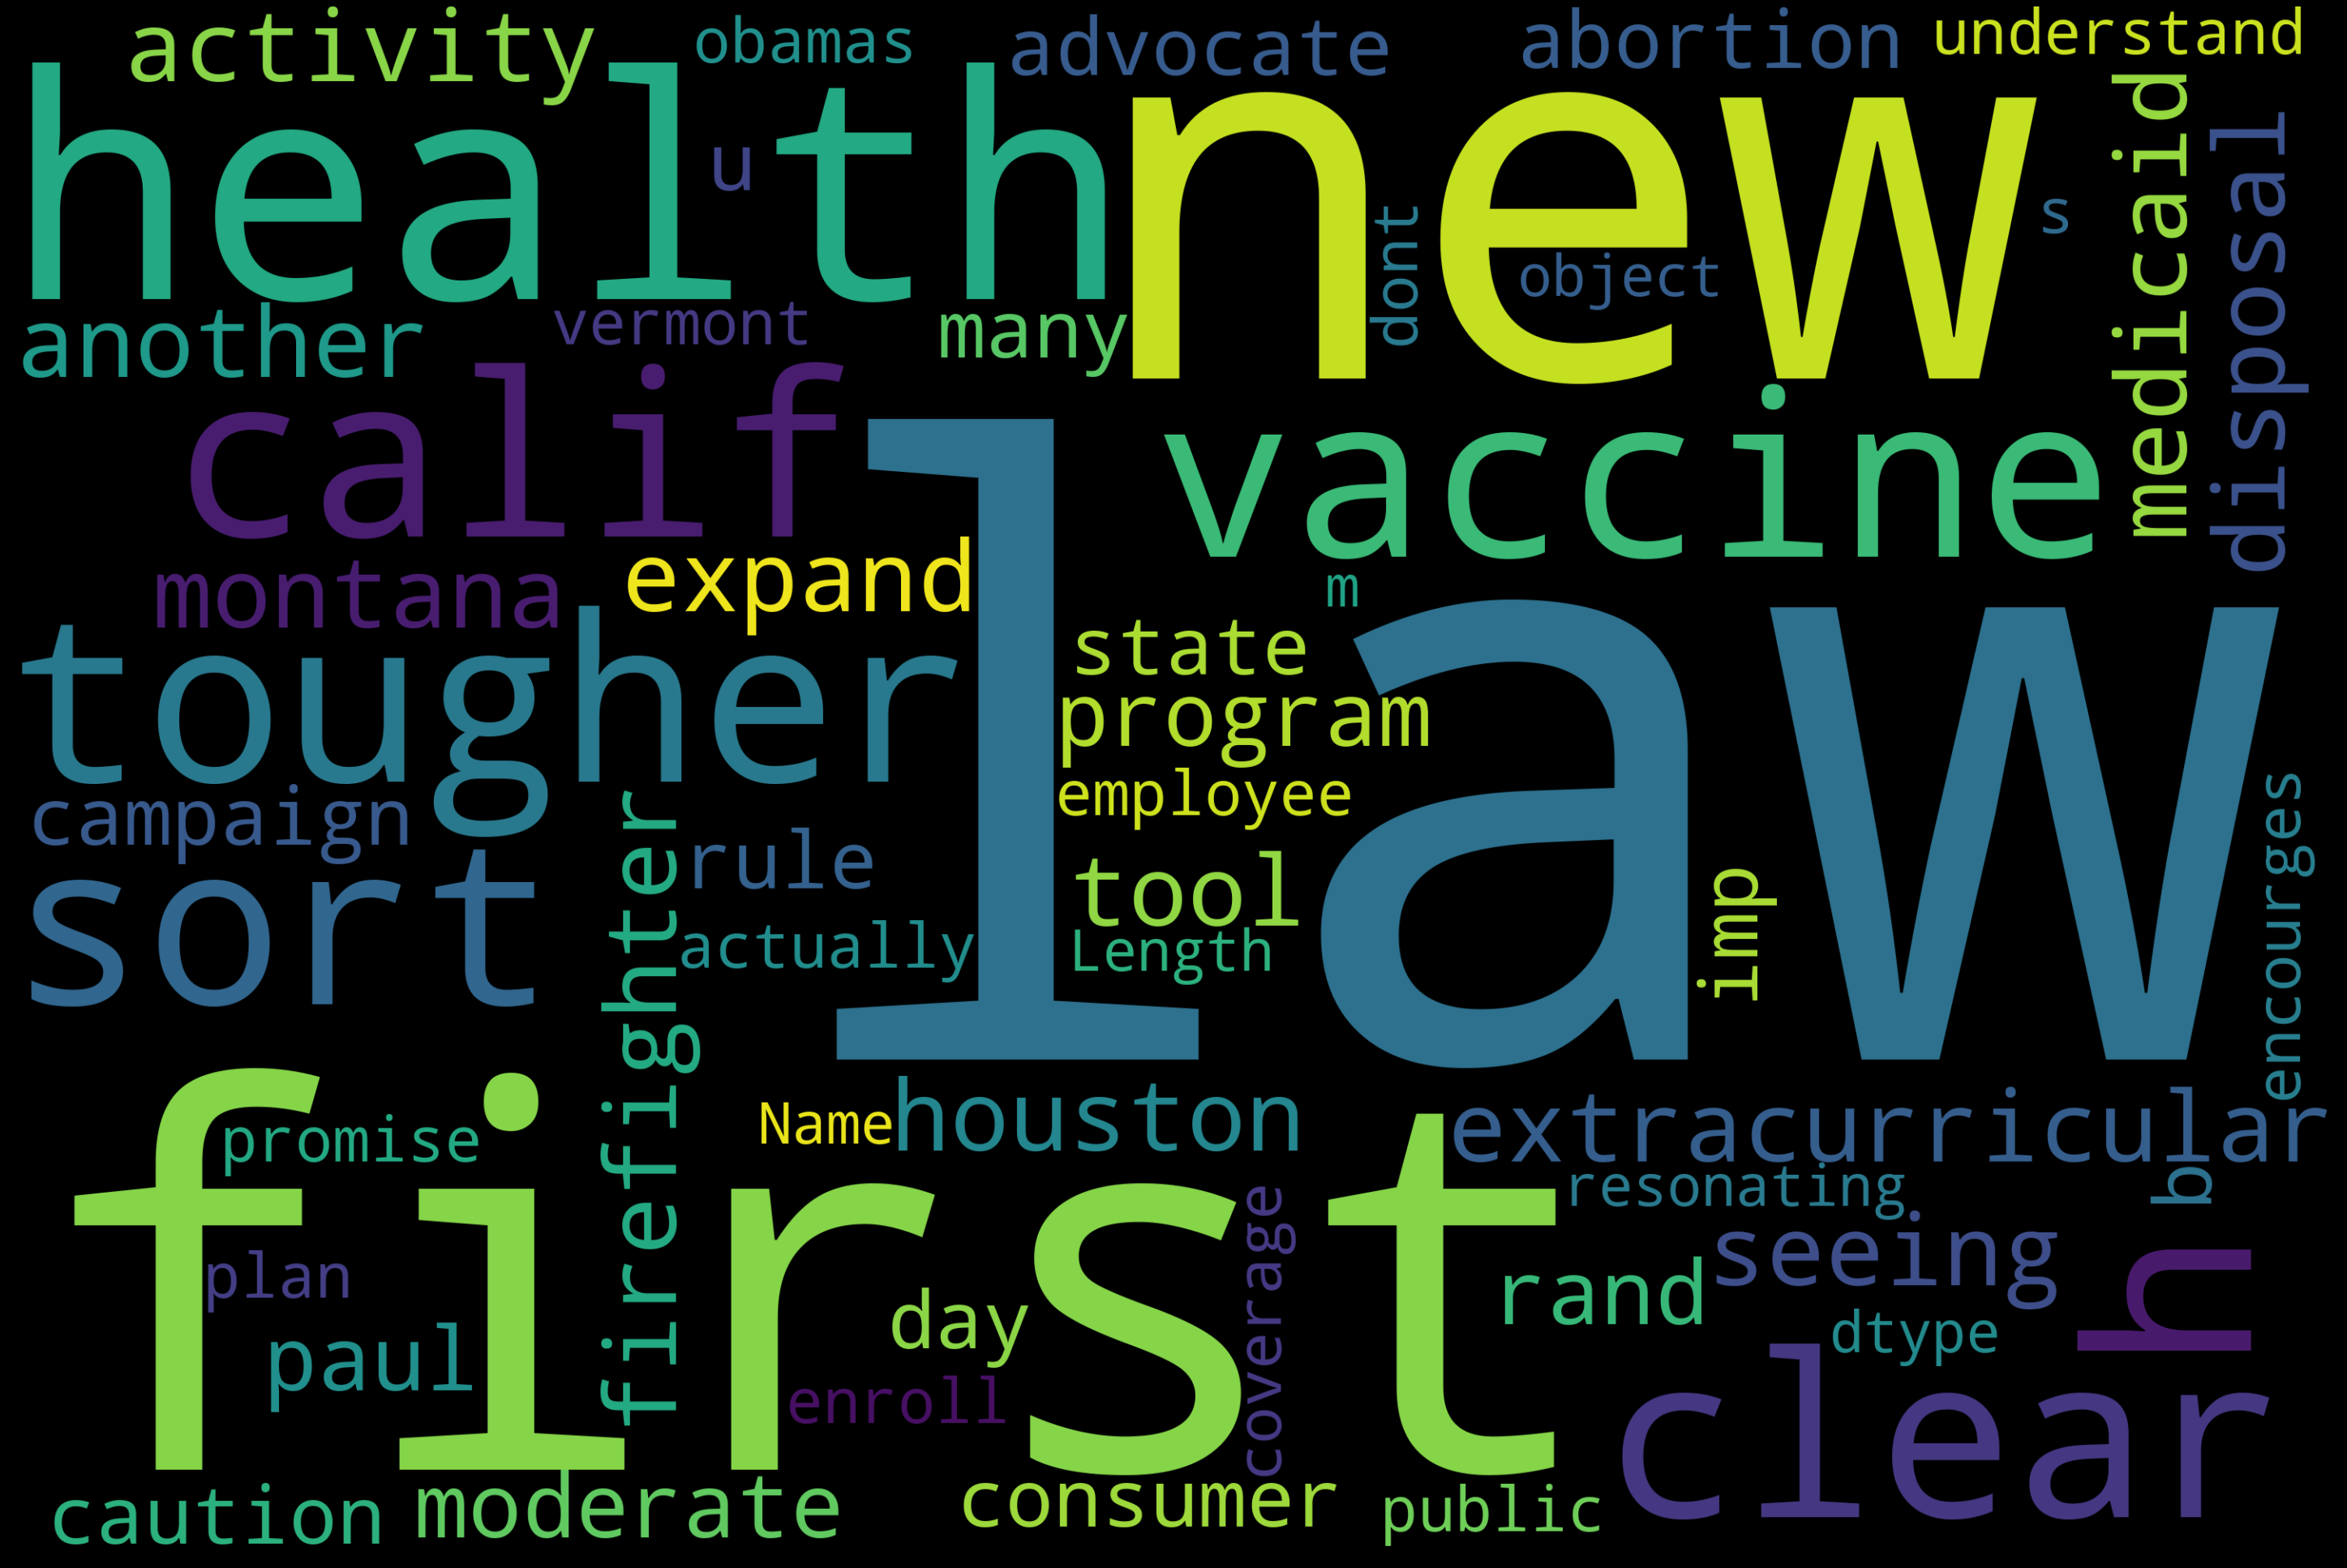

In [135]:
word_cloud(news_k_df['news'])

2. Tree map

Text(0.5, 1.0, 'Tree Map')

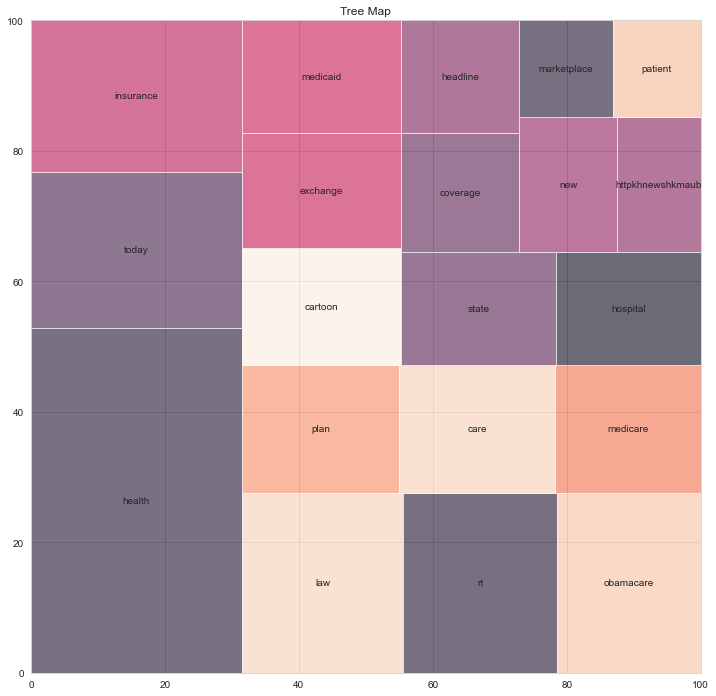

In [136]:
plt.figure(figsize = (12, 12))
sns.set_style(style = "whitegrid")
sizes = most_common_k_df['count'].values
label = most_common_k_df['word']
squarify.plot(sizes = sizes, label = label, alpha = 0.6)
plt.title("Tree Map")

3. Bubble Graph

In [137]:
graph = px.scatter(most_common_k_df, x = "word", y = "count", hover_name = "word", size = "count", color = "word")
graph.show()

# Part C

Discussion: When we compare the results from the two datasets(news sources), one from the reuters and one from the Kaiser, we can see what the two news focus upon, what two words are used together most of the time. Looking at the word frequency we can see, for reuters the most common word came out to be Ebola, which means most of the news was focussed upon the affect of ebola virus, how it was spreading and the city under focus was Los Angeles. 
In the news from Kaiser news, the most used word was health. And from understanding of the bigrams and trigrams, we come to know the news is about some health law, which is regarding the health insurance.